# Import library

In [40]:
import os

import numpy as np
import seaborn as sns
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import TensorBoard
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import l2
from keras.models import Sequential
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

# Load DATA

In [5]:
DATA_PATH = os.path.join('C:/Rafif/SKRIPSI/Proyek Skripsi - Pycharm/DATA')
gestures = np.array(['pain or ill', 'nurse, call bell', 'toilet', 'change that', 'hot', 'doctor, nurse', 'lie down',
                     'turn over', 'medication', 'frightened, worried', 'sit', 'wash', 'cold', 'food', 'drink',
                     'teeth, dentures', 'fetch, need that', 'home', 'spectacles', 'book or magazine',
                     'stop, finish that', 'yes, good', 'help me', 'no, bad'])
no_sequence = 15
sequence_length = 10
start_folder = 0

In [8]:
no_sequences = 190
label_map = {label: num for num, label in enumerate(gestures)}
# print(label_map)
sequences, labels = [], []
for gesture in gestures:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, gesture, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[gesture])

# LSTM model

In [58]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(10, 63)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(gestures.shape[0], activation='softmax'))

# Split data

In [9]:
X = np.array(sequences)

In [12]:
y = to_categorical(labels).astype(int)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

In [23]:
X_train.shape, y_train.shape

((3693, 10, 63), (3693, 24))

In [24]:
X_test.shape, y_test.shape

((456, 10, 63), (456, 24))

In [25]:
X_val.shape, y_val.shape

((411, 10, 63), (411, 24))

# Evaluate Parameter

In [32]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

# Train Model

In [59]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [60]:
es_callback = [EarlyStopping(monitor='val_loss', patience=10),
               #ModelCheckpoint(filepath='skripsi.h5', monitor='val_loss', save_best_only=True)]

In [61]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',
              metrics=['categorical_accuracy', f1_m, precision_m, recall_m])

In [62]:
history = model.fit(X_train, y_train, batch_size=32, epochs=2000, callbacks=[tb_callback, es_callback],
                        validation_data=(X_val, y_val))

Epoch 1/2000
116/116 [==============================] - 6s 22ms/step - loss: 3.0897 - categorical_accuracy: 0.0636 - f1_m: 0.0051 - precision_m: 0.0647 - recall_m: 0.0027 - val_loss: 2.8576 - val_categorical_accuracy: 0.1338 - val_f1_m: 0.0365 - val_precision_m: 0.4359 - val_recall_m: 0.0192
Epoch 2/2000
116/116 [==============================] - 2s 18ms/step - loss: 2.7941 - categorical_accuracy: 0.1511 - f1_m: 0.0183 - precision_m: 0.1983 - recall_m: 0.0097 - val_loss: 2.6121 - val_categorical_accuracy: 0.1849 - val_f1_m: 0.0140 - val_precision_m: 0.2308 - val_recall_m: 0.0072
Epoch 3/2000
116/116 [==============================] - 2s 18ms/step - loss: 2.4922 - categorical_accuracy: 0.2342 - f1_m: 0.0629 - precision_m: 0.4536 - recall_m: 0.0349 - val_loss: 2.4565 - val_categorical_accuracy: 0.2433 - val_f1_m: 0.0615 - val_precision_m: 0.5038 - val_recall_m: 0.0337
Epoch 4/2000
116/116 [==============================] - 2s 18ms/step - loss: 2.2037 - categorical_accuracy: 0.3317 - f1_m

Epoch 29/2000
116/116 [==============================] - 2s 17ms/step - loss: 0.6086 - categorical_accuracy: 0.8040 - f1_m: 0.8138 - precision_m: 0.8716 - recall_m: 0.7650 - val_loss: 0.8107 - val_categorical_accuracy: 0.7810 - val_f1_m: 0.7955 - val_precision_m: 0.8499 - val_recall_m: 0.7482
Epoch 30/2000
116/116 [==============================] - 2s 18ms/step - loss: 0.5644 - categorical_accuracy: 0.8253 - f1_m: 0.8314 - precision_m: 0.8826 - recall_m: 0.7873 - val_loss: 0.9067 - val_categorical_accuracy: 0.7397 - val_f1_m: 0.7562 - val_precision_m: 0.8358 - val_recall_m: 0.6916
Epoch 31/2000
116/116 [==============================] - 2s 18ms/step - loss: 0.5724 - categorical_accuracy: 0.8115 - f1_m: 0.8193 - precision_m: 0.8682 - recall_m: 0.7771 - val_loss: 0.8753 - val_categorical_accuracy: 0.7494 - val_f1_m: 0.7664 - val_precision_m: 0.8289 - val_recall_m: 0.7132
Epoch 32/2000
116/116 [==============================] - 2s 18ms/step - loss: 0.5655 - categorical_accuracy: 0.8199 - 

# Evaluate Model

In [63]:
loss, accuracy, f1_score, precision, recall, = model.evaluate(X_test, y_test, verbose=0)
print("Loss: {}, Accuracy: {:5.2f}%, F1 Score: {}, Precision: {}, Recall: {}".format(loss, 100 * accuracy,
                                                                                         f1_score, precision,
                                                                                         recall, ))

Loss: 0.7552118897438049, Accuracy: 81.36%, F1 Score: 0.8258395791053772, Precision: 0.8646215796470642, Recall: 0.7916666865348816


In [64]:
yhat = model.predict(X_test)
ytrue = np.argmax(y_test, axis=1)
yhat = np.argmax(yhat, axis=1)
cm = confusion_matrix(ytrue, yhat)

15/15 [==============================] - 0s 7ms/step


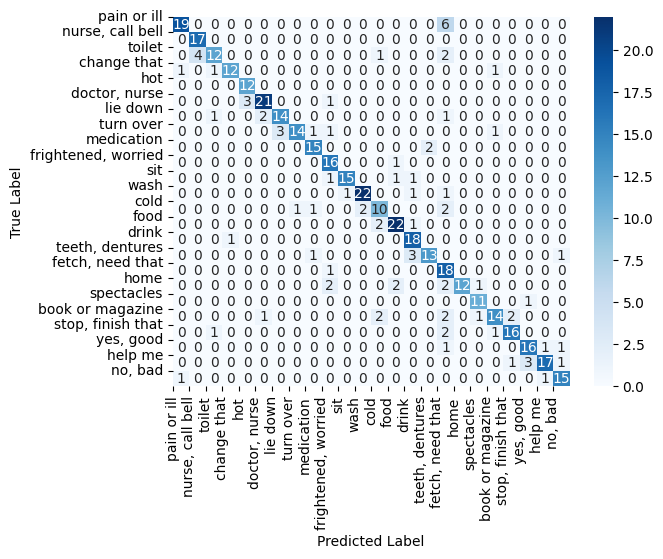

In [65]:
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.yticks(np.arange(len(gestures)), gestures.tolist())
plt.xticks(np.arange(len(gestures)), gestures.tolist())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

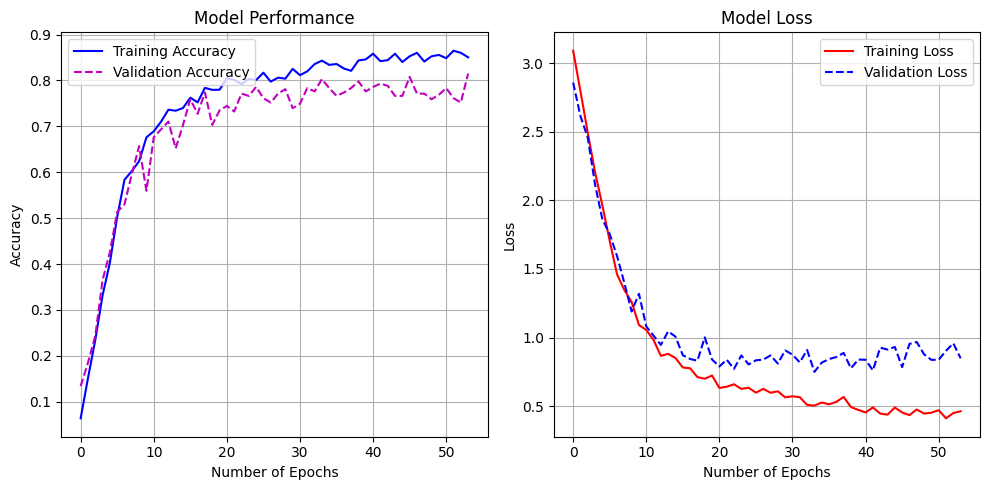

In [66]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plot accuracy and validation accuracy on the first subplot
ax1.plot(history.history['categorical_accuracy'], label='Training Accuracy', color='b', linestyle='solid')
ax1.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy', color='m', linestyle='dashed')

# Add title, labels, and legend to the first subplot
ax1.set_title('Model Performance')
ax1.set_xlabel('Number of Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='upper left')
ax1.grid(True)

# Plot training and validation loss on the second subplot
ax2.plot(history.history['loss'], label='Training Loss', color='r', linestyle='solid')
ax2.plot(history.history['val_loss'], label='Validation Loss', color='b', linestyle='dashed')

# Add title, labels, and legend to the second subplot
ax2.set_title('Model Loss')
ax2.set_xlabel('Number of Epochs')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')
ax2.grid(True)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()